# **Movie Genre Classification**

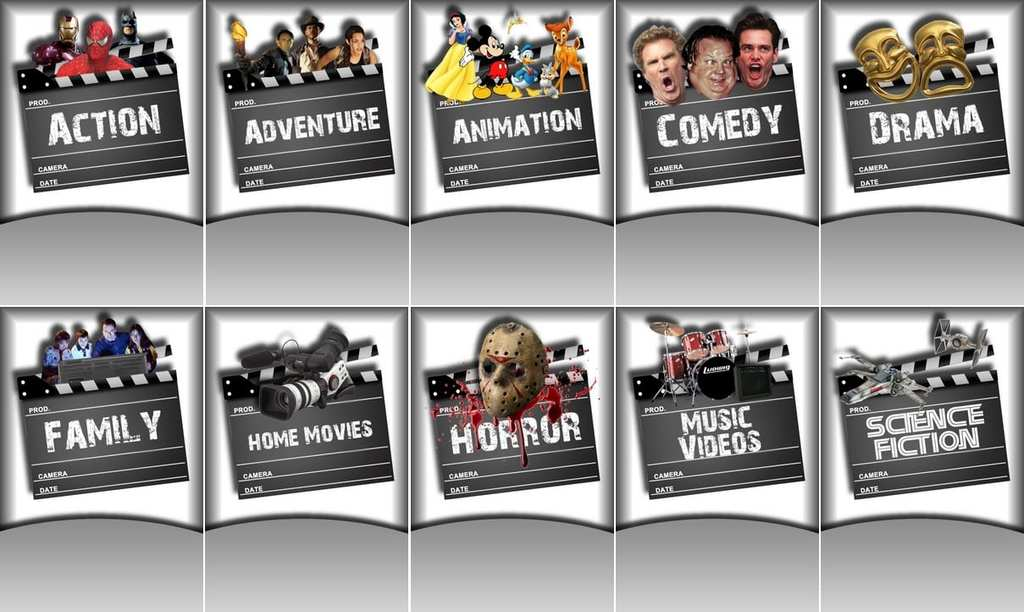

## **About Dataset**

IMDb (an acronym for Internet Movie Database) is an online database of information related to films, television programs, home videos, video games, and streaming content online including cast, production crew and personal biographies, plot summaries, trivia, ratings, and fan and critical reviews. An additional fan feature, message boards, was abandoned in February 2017. Originally a fan-operated website, the database is now owned and operated by IMDb.com, Inc., a subsidiary of Amazon.

As of December 2020, IMDb has approximately 7.5 million titles (including episodes) and 10.4 million personalities in its database,as well as 83 million registered users.

IMDb began as a movie database on the Usenet group "rec.arts.movies" in 1990 and moved to the web in 1993.

## **Objective**
Build a machine learning model that can predict a genre of a movie based on the description of that particular movie.

In [ ]:
# Import needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read a txt file as a csv
train_df = pd.read_csv("/content/drive/MyDrive/Docs for collab/Movie/train_data.txt", sep=':::', names=["title", "genre", "description"], engine='python')

In [ ]:
# Display the data
train_df.head()

,title,genre,description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [ ]:
# Checking Null Values
train_df.isnull().sum()

title          0
genre          0
description    0
dtype: int64

In [ ]:
# Get the unique values in Genre column
print('No. unique values in genre',train_df.genre.nunique())
train_df.genre.value_counts()

No. unique values in genre 27


genre
 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: count, dtype: int64

[Text(0.5, 1.0, 'Top 10 Genres with count')]

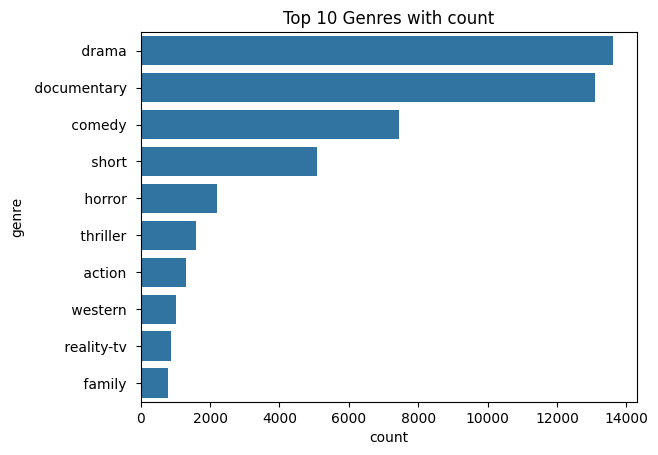

In [ ]:
# Plot top 10 genres by count
genre = pd.DataFrame(train_df.genre.value_counts()).reset_index().head(10)
sns.barplot(x='count',y='genre',data=genre).set(title='Top 10 Genres with count')

# **NLP Operations on Description column**

In [ ]:
# Creation of variables for txt preprocessing
nltk.download('stopwords')
nltk.download('punkt')
PS = PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# column of description length
train_df['Desc length'] = train_df['description'].apply(len)

In [ ]:
# Function for Txt Preprocessing
def txt_preprocess(description):
  description = description.lower()
  description = re.sub(r'@\S+','',description)
  description = re.sub(r'http\S+', '', description)
  description = re.sub(r'[\w\.-]+@[\w\.-]+',"",description)
  description = re.sub(r"[^a-zA-Z+']", ' ', description)
  description = re.sub('-',' ',description.lower())
  word_tokens = word_tokenize(description)
  sw_removal = []
  filtered_article = []
  for word in word_tokens:
    if word not in stopwords:
       sw_removal.append(word)
  for i in sw_removal:
    filtered_article.append(PS.stem(i))
  return ' '.join(filtered_article)

In [ ]:
# Column of preprocessed txt
train_df['Processed Description'] = train_df.description.apply(txt_preprocess)

In [ ]:
# column for preprocessed txt length
train_df['Processed Desc length'] = train_df['Processed Description'].apply(len)

In [ ]:
# get the length greater than 2000 in preprocessed description
(train_df['Processed Desc length']>2000).value_counts()

Processed Desc length
False    54091
True       123
Name: count, dtype: int64

In [ ]:
# remove the rows that the length greater than 2000 in preprocessed description
train_df = train_df[~(train_df['Processed Desc length']>2000)]

In [ ]:
# Label Encoding for Genre column
le = LabelEncoder()
le.fit(train_df['genre'])
train_df['genre_le'] = le.transform(train_df['genre'])

In [ ]:
# for future use
le.inverse_transform([21])

array([' short '], dtype=object)

In [ ]:
train_df

,title,genre,description,Desc length,Processed Description,Processed Desc length,genre_le
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,listen convers doctor parent year old oscar le...,339,8
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,brother sister past incestu relationship curre...,111,24
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bu empti student field trip museum natur histo...,346,1
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy father make end meet edith twin ...,681,8
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,film 's titl refer un recov bodi ground zero a...,353,8
...,...,...,...,...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...,507,short live nbc live sitcom center bonino world...,322,5
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...,781,next gener exploit sister kapa bay soror hous ...,468,13
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g...",255,ze bestaan echt stand comedi grow face fear fr...,116,7
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...,642,walter vivian live countri difficult time keep...,367,5


In [ ]:
# Average No. words in a description column
print('Average length of a description before preprocess',train_df['Desc length'].mean())
print('Average length of a description after preprocess',train_df['Processed Desc length'].mean())

Average length of a description before preprocess 591.6775433990867
Average length of a description after preprocess 360.88913127877095


In [ ]:
# Spliting the data for prediction
X = train_df['Processed Description']
y = train_df['genre_le']

In [ ]:
# Vectorization on description column using Tf idf Vectorizer
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(X)
x_vector = x.toarray()

In [ ]:
# DataFrame after Vectorization
pd.DataFrame(data=x_vector,columns=vectorizer.get_feature_names_out())

,aa,aaa,aaadyatm,aabhaasam,aabhraan,aachi,aadam,aadamkhor,aadar,aadi,...,zygielbojm,zygmont,zygmunt,zygon,zykov,zyler,zylkin,zypcio,zyzyphu,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Train Test split
X_train,X_test,y_train,y_test = train_test_split(x_vector,y,test_size=0.2,random_state=0)
X_train.shape

(43272, 88602)

# **Model Building**

## **1) Logistic Regression**

In [ ]:
lr = LogisticRegression(penalty='l1',solver='liblinear',C=1.0)
lr.fit(X_train,y_train)
lr.score(X_train,y_train),lr.score(X_test,y_test)

(0.6249768903679054, 0.581199741196044)

In [ ]:
# Classification Report
y_pred = lr.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.56      0.26      0.36       283
           1       0.66      0.39      0.49       119
           2       0.57      0.17      0.26       154
           3       0.35      0.07      0.12        98
           4       0.00      0.00      0.00        51
           5       0.56      0.56      0.56      1482
           6       0.42      0.05      0.09       103
           7       0.66      0.83      0.74      2616
           8       0.53      0.79      0.63      2752
           9       0.39      0.08      0.13       151
          10       0.43      0.05      0.08        64
          11       0.76      0.69      0.72        36
          12       0.00      0.00      0.00        50
          13       0.62      0.56      0.59       444
          14       0.50      0.38      0.43       123
          15       0.50      0.05      0.09        60
          16       0.45      0.08      0.13        64
          17       1.00    

## **2) Multinomial NB**

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
mnb.score(X_train,y_train),mnb.score(X_test,y_test)

(0.4625855056387502, 0.4393197153156484)

In [ ]:
# Classification Report
y_pred = mnb.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       283
           1       0.00      0.00      0.00       119
           2       0.00      0.00      0.00       154
           3       0.00      0.00      0.00        98
           4       0.00      0.00      0.00        51
           5       0.59      0.04      0.07      1482
           6       0.00      0.00      0.00       103
           7       0.51      0.90      0.65      2616
           8       0.38      0.85      0.53      2752
           9       0.00      0.00      0.00       151
          10       0.00      0.00      0.00        64
          11       0.00      0.00      0.00        36
          12       0.00      0.00      0.00        50
          13       0.00      0.00      0.00       444
          14       0.00      0.00      0.00       123
          15       0.00      0.00      0.00        60
          16       0.00      0.00      0.00        64
          17       0.00    

## **3) Decision Tree**

In [ ]:
dtc = DecisionTreeClassifier(criterion='gini',max_depth=12,min_samples_split=24)
dtc.fit(X_train,y_train)
dtc.score(X_train,y_train),dtc.score(X_test,y_test)

(0.41613514512848954, 0.3975413624179684)

In [ ]:
# Classification Report
y_pred = dtc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       283
           1       0.00      0.00      0.00       119
           2       0.43      0.02      0.04       154
           3       0.00      0.00      0.00        98
           4       0.00      0.00      0.00        51
           5       0.38      0.24      0.30      1482
           6       0.00      0.00      0.00       103
           7       0.60      0.58      0.59      2616
           8       0.32      0.82      0.46      2752
           9       0.00      0.00      0.00       151
          10       0.00      0.00      0.00        64
          11       0.00      0.00      0.00        36
          12       0.00      0.00      0.00        50
          13       0.48      0.10      0.16       444
          14       0.33      0.02      0.03       123
          15       0.00      0.00      0.00        60
          16       0.00      0.00      0.00        64
          17       0.00    

# **Result**

In [ ]:
accuracy = {'Model':['Logistic Regression','Multinomial NB','Decision Tree'],
            'Accuracy':[58.129,43.931,39.754]}
pd.DataFrame(accuracy)

,Model,Accuracy
0,Logistic Regression,58.129
1,Multinomial NB,43.931
2,Decision Tree,39.754


From above dataframe we can conclude logistic regression has a highest accuracy. So we can take this model as a predictor.  

# **Prediction**

In [ ]:
# Sample Description
# Actual genre is Documentary
des = "One year in the life of Albin and his family of shepherds in the North of Transylvania. In direct cinema style, this documentary follows their day to day routines, and their struggle to adapt to a new world where traditions are gradually replaced by modern values. Since joining the EU, Romania has been facing, like several other Eastern European countries, the pressure of modern values, introducing in farmer's lives the cruel notion of competition, the temptation of migrating to the higher salaries abroad, and the marginalization of locally produced food against industrial products."

In [ ]:
# Text Preprocessing using txt_preprocess function
txt = txt_preprocess(des)

In [ ]:
# Vectorization of processed text
x = vectorizer.transform([txt])

In [ ]:
# Model prediction
gen = list(lr.predict(x))
pr = le.inverse_transform([gen])[0]
print('Predicted Genre is :',pr.upper())

Predicted Genre is :  DOCUMENTARY 


This Dataset has a high number of Drama and Documentray genres so our model often predicts these two types.